Previous strategies
a. Use weyl chamber coordinates to canonicalize the target unitary, then use exact spanning rules to rebuild the canonical gate
b. Use nuop to minimize hilbertschmidt distance between the template and the target, search over an expanding target in a predefined range of length

New strategy:
a. minimize distance between the template and target weyl chamber coordinates - easier than exact spanning rules, and I suspect may be faster than NuOp.
Key heurtistic: weyl chamber coordinates contain more local variational similarity than unitary representations (?) not sure how to phrase this
what I mean is that if I am at a point in the Weyl chamber (the current state of my target unitary), then adding another gate preserves the closeness of the orginal point. Whereas, just comparing the unitaries does not...I'm not sure this makes sense or is even true.
Extends to mixed bags riswap


Notes thus far:
1- trying to build the template piece by piece doesn't seem to work - need to modify all the 1Q gates at the same time, not just the newest layer, which is not what I was expecting. Unfortunately, building the template altogether takes significantly longer than piece by piece.
2- noticed that chamber coordinats may be better than schmidt hilbert distance - more gates lie on same coordinates (e.g. CNOT and CPHASe are identical in weyl, but have .5 hilbert schmidt distance)
3- I still believe there is some more clever variational information to be learned. characterize the change in vecctors as a function of change in parameters
4- I could try training a QNN then have a model that can do inferencing that acts like a closed form solution
5- can I use both hilbert-schmidt and weyl? multi-objective learning that priotizes coordinates then hilbert-schmidt?
6- 

In [16]:
import sys

sys.path.append("..")

In [17]:
# the following is from Qiskits two_qubit_decomp, (doesn't work as import since need to adjust parameters and return vals)
import cmath
from qiskit.quantum_info.synthesis.two_qubit_decompose import *
import scipy.linalg as la

_ipx = np.array([[0, 1j], [1j, 0]], dtype=complex)
_ipy = np.array([[0, 1], [-1, 0]], dtype=complex)
_ipz = np.array([[1j, 0], [0, -1j]], dtype=complex)
_id = np.array([[1, 0], [0, 1]], dtype=complex)


def KAKDecomp(unitary_matrix, *, fidelity=(1.0 - 1.0e-9)):
    """Perform the Weyl chamber decomposition, and optionally choose a specialized subclass.

    The flip into the Weyl Chamber is described in B. Kraus and J. I. Cirac, Phys. Rev. A 63,
    062309 (2001).

    FIXME: There's a cleaner-seeming method based on choosing branch cuts carefully, in Andrew
    M. Childs, Henry L. Haselgrove, and Michael A. Nielsen, Phys. Rev. A 68, 052311, but I
    wasn't able to get that to work.

    The overall decomposition scheme is taken from Drury and Love, arXiv:0806.4015 [quant-ph].
    """
    pi = np.pi
    pi2 = np.pi / 2
    pi4 = np.pi / 4

    # Make U be in SU(4)
    U = np.array(unitary_matrix, dtype=complex, copy=True)
    detU = la.det(U)
    U *= detU ** (-0.25)
    global_phase = cmath.phase(detU) / 4

    Up = transform_to_magic_basis(U, reverse=True)
    M2 = Up.T.dot(Up)

    # M2 is a symmetric complex matrix. We need to decompose it as M2 = P D P^T where
    # P ∈ SO(4), D is diagonal with unit-magnitude elements.
    #
    # We can't use raw `eig` directly because it isn't guaranteed to give us real or othogonal
    # eigenvectors.  Instead, since `M2` is complex-symmetric,
    #   M2 = A + iB
    # for real-symmetric `A` and `B`, and as
    #   M2^+ @ M2 = A^2 + B^2 + i [A, B] = 1
    # we must have `A` and `B` commute, and consequently they are simultaneously diagonalizable.
    # Mixing them together _should_ account for any degeneracy problems, but it's not
    # guaranteed, so we repeat it a little bit.  The fixed seed is to make failures
    # deterministic; the value is not important.
    state = np.random.default_rng(2020)
    for _ in range(100):  # FIXME: this randomized algorithm is horrendous
        M2real = state.normal() * M2.real + state.normal() * M2.imag
        _, P = np.linalg.eigh(M2real)
        D = P.T.dot(M2).dot(P).diagonal()
        if np.allclose(P.dot(np.diag(D)).dot(P.T), M2, rtol=0, atol=1.0e-13):
            break
    else:
        raise ValueError

    d = -np.angle(D) / 2
    d[3] = -d[0] - d[1] - d[2]
    cs = np.mod((d[:3] + d[3]) / 2, 2 * np.pi)

    # Reorder the eigenvalues to get in the Weyl chamber
    cstemp = np.mod(cs, pi2)
    np.minimum(cstemp, pi2 - cstemp, cstemp)
    order = np.argsort(cstemp)[[1, 2, 0]]
    cs = cs[order]
    d[:3] = d[order]
    P[:, :3] = P[:, order]

    # Fix the sign of P to be in SO(4)
    if np.real(la.det(P)) < 0:
        P[:, -1] = -P[:, -1]

    # Find K1, K2 so that U = K1.A.K2, with K being product of single-qubit unitaries
    K1 = transform_to_magic_basis(Up @ P @ np.diag(np.exp(1j * d)))
    K2 = transform_to_magic_basis(P.T)

    K1l, K1r, phase_l = decompose_two_qubit_product_gate(K1)
    K2l, K2r, phase_r = decompose_two_qubit_product_gate(K2)
    global_phase += phase_l + phase_r

    K1l = K1l.copy()

    # Flip into Weyl chamber
    if cs[0] > pi2:
        cs[0] -= 3 * pi2
        K1l = K1l.dot(_ipy)
        K1r = K1r.dot(_ipy)
        global_phase += pi2
    if cs[1] > pi2:
        cs[1] -= 3 * pi2
        K1l = K1l.dot(_ipx)
        K1r = K1r.dot(_ipx)
        global_phase += pi2
    conjs = 0
    if cs[0] > pi4:
        cs[0] = pi2 - cs[0]
        K1l = K1l.dot(_ipy)
        K2r = _ipy.dot(K2r)
        conjs += 1
        global_phase -= pi2
    if cs[1] > pi4:
        cs[1] = pi2 - cs[1]
        K1l = K1l.dot(_ipx)
        K2r = _ipx.dot(K2r)
        conjs += 1
        global_phase += pi2
        if conjs == 1:
            global_phase -= pi
    if cs[2] > pi2:
        cs[2] -= 3 * pi2
        K1l = K1l.dot(_ipz)
        K1r = K1r.dot(_ipz)
        global_phase += pi2
        if conjs == 1:
            global_phase -= pi
    if conjs == 1:
        cs[2] = pi2 - cs[2]
        K1l = K1l.dot(_ipz)
        K2r = _ipz.dot(K2r)
        global_phase += pi2
    if cs[2] > pi4:
        cs[2] -= pi2
        K1l = K1l.dot(_ipz)
        K1r = K1r.dot(_ipz)
        global_phase -= pi2

    a, b, c = cs[1], cs[0], cs[2]
    return global_phase, (a, b, c), K1l, K1r, K2l, K2r

In [18]:
from qiskit.circuit import Parameter


class ParamIter:
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        x = self.index
        self.index += 1
        return Parameter(f"p{x}")


# print(next(myiter))
# print(next(myiter))

In [66]:
from clonk.utils.riswap_gates.riswap import RiSwapGate

"""
Efficient compiler consturction of parameterized circuits
https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html

"""


def template_circuit(param_list, base=None):
    myiter = iter(ParamIter())
    if base is None:
        qc = QuantumCircuit(2)
        qc.u(*[next(myiter) for _ in range(3)], 0)
        qc.u(*[next(myiter) for _ in range(3)], 1)
    else:
        qc = base.copy()
    for param in param_list:
        qc.append(RiSwapGate(1 / param), [0, 1])
        qc.u(*[next(myiter) for _ in range(3)], 0)
        qc.u(*[next(myiter) for _ in range(3)], 1)
    return qc


qc = template_circuit([2])
qc.draw()

┌─────────────┐┌─────────────────┐ ┌─────────────┐ 
q_0: ┤ U(p0,p1,p2) ├┤0                ├─┤ U(p6,p7,p8) ├─
     ├─────────────┤│  iSwap^0.5(0.5) │┌┴─────────────┴┐
q_1: ┤ U(p3,p4,p5) ├┤1                ├┤ U(p9,p10,p11) ├
     └─────────────┘└─────────────────┘└───────────────┘

In [72]:
from qiskit.quantum_info import random_unitary, Operator
from qiskit import QuantumCircuit

target_qc = QuantumCircuit(2)
target_qc.append(random_unitary(dims=(2, 2)), [0, 1])
global_phase, (a, b, c), K1l, K1r, K2l, K2r = KAKDecomp(Operator(target_qc).data)
target_coordinates = (a, b, c)
print(target_coordinates)

(0.47830846453879516, 0.3021961415154081, -0.0007979947734835235)


In [31]:
def unitary_distance_function(A, B):
    # return (1 - np.abs(np.sum(np.multiply(B,np.conj(np.transpose(A))))) / 4)
    # return (1 - (np.abs(np.sum(np.multiply(B,np.conj(A)))))**2+4 / 20) # quantum volume paper
    return 1 - np.abs(np.sum(np.multiply(B, np.conj(A)))) / 4

0.12458083884667513
1.2285080241445403e-07
1.2159259149472528e-07
1.2159259149472528e-07


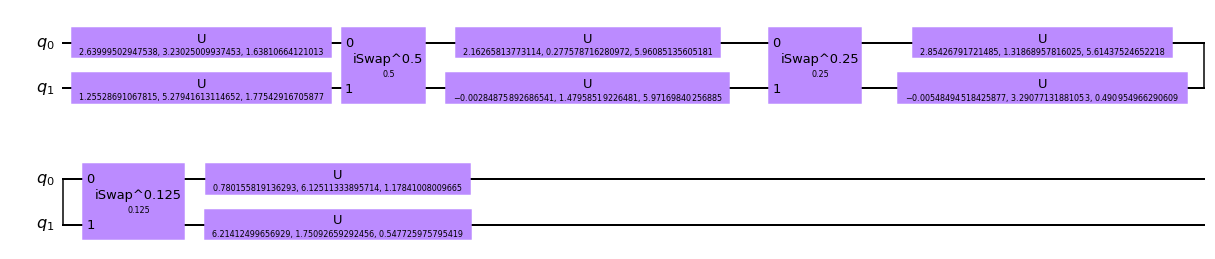

In [86]:
%matplotlib inline
from scipy.optimize import minimize


def sample(param_list, N=1000):
    #
    iter = []
    current_best = []
    nuop_distance = []
    #
    minimum_qc = None
    min_distance = None
    modified_template = None

    for template_index in range(0, len(param_list)):
        modified_params = param_list[: 1 + template_index]
        template_qc = template_circuit(modified_params, base=modified_template)
        initial_guess = np.random.random(len(template_qc.parameters)) * 2 * np.pi
        #
        qc = template_circuit(modified_params, base=modified_template)

        def min_fun(x):
            temp_qc = qc.assign_parameters(
                {parameter: i for parameter, i in zip(qc.parameters, x)}
            )
            _, (a, b, c), _, _, _, _ = KAKDecomp(Operator(temp_qc).data)
            temp_coordinates = (a, b, c)
            return np.linalg.norm(
                np.array(target_coordinates) - np.array(temp_coordinates)
            )

        min_result = minimize(fun=min_fun, x0=initial_guess)
        # #
        # for _ in range(N):
        #     qc = template_circuit(modified_params, base=modified_template)
        #     parameters = qc.parameters
        #     temp_qc = qc.assign_parameters({parameter:np.random.random()*2*np.pi for parameter in parameters})
        #     global_phase, (a, b, c), K1l, K1r, K2l, K2r = KAKDecomp(Operator(temp_qc).data)
        #     temp_coordinates = (a,b,c)
        #     temp_dist = np.linalg.norm(np.array(target_coordinates)-np.array(temp_coordinates))
        #     if min_distance is None or temp_dist < min_distance:
        #         minimum_qc = temp_qc
        #         min_distance = temp_dist
        #     #
        #     current_best.append(min_distance)
        #     nuop_distance.append(unitary_distance_function(Operator(minimum_qc).data, Operator(target_qc).data))
        # #

        # modified_template = template_qc.assign_parameters({parameter:i for parameter,i in zip(template_qc.parameters,min_result.x)})
        min_distance = min_result.fun
        print(min_distance)

    modified_template = template_qc.assign_parameters(
        {parameter: i for parameter, i in zip(template_qc.parameters, min_result.x)}
    )

    # import matplotlib.pyplot as plt
    # plt.plot(range(len(current_best)), current_best, label="coords")
    # plt.plot(range(len(current_best)), nuop_distance, label="nuop")
    # plt.yscale('log')
    return modified_template, min_result.fun


minimum_qc, min_distance = sample([2, 4, 8])
print(min_distance)
minimum_qc.draw(output="mpl")

0.12458083884667484
0.2761219500343271
0.26000939836380854
0.26000939836380854


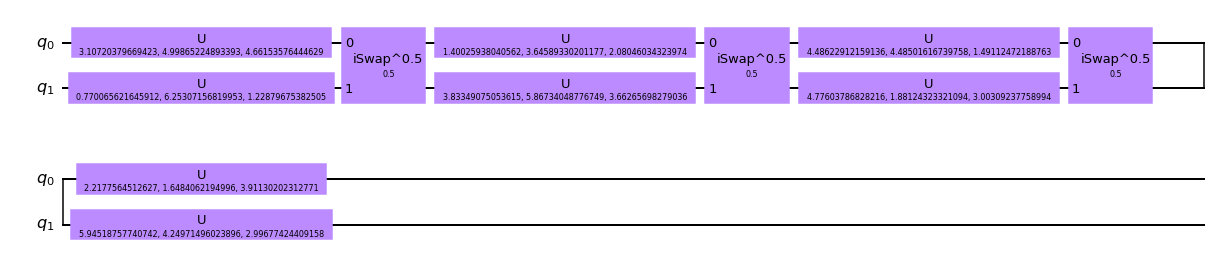

In [83]:
%matplotlib inline
from scipy.optimize import minimize


def sample(param_list, N=1000):
    #
    iter = []
    current_best = []
    nuop_distance = []
    #
    minimum_qc = None
    min_distance = None
    modified_template = None

    for template_index in range(0, len(param_list)):
        modified_params = param_list[template_index : 1 + template_index]
        template_qc = template_circuit(modified_params, base=modified_template)
        initial_guess = np.random.random(len(template_qc.parameters)) * 2 * np.pi
        #
        qc = template_circuit(modified_params, base=modified_template)

        def min_fun(x):
            temp_qc = qc.assign_parameters(
                {parameter: i for parameter, i in zip(qc.parameters, x)}
            )
            _, (a, b, c), _, _, _, _ = KAKDecomp(Operator(temp_qc).data)
            temp_coordinates = (a, b, c)
            return np.linalg.norm(
                np.array(target_coordinates) - np.array(temp_coordinates)
            )

        min_result = minimize(fun=min_fun, x0=initial_guess)
        # #
        # for _ in range(N):
        #     qc = template_circuit(modified_params, base=modified_template)
        #     parameters = qc.parameters
        #     temp_qc = qc.assign_parameters({parameter:np.random.random()*2*np.pi for parameter in parameters})
        #     global_phase, (a, b, c), K1l, K1r, K2l, K2r = KAKDecomp(Operator(temp_qc).data)
        #     temp_coordinates = (a,b,c)
        #     temp_dist = np.linalg.norm(np.array(target_coordinates)-np.array(temp_coordinates))
        #     if min_distance is None or temp_dist < min_distance:
        #         minimum_qc = temp_qc
        #         min_distance = temp_dist
        #     #
        #     current_best.append(min_distance)
        #     nuop_distance.append(unitary_distance_function(Operator(minimum_qc).data, Operator(target_qc).data))
        # #

        modified_template = template_qc.assign_parameters(
            {parameter: i for parameter, i in zip(template_qc.parameters, min_result.x)}
        )
        min_distance = min_result.fun
        print(min_distance)

    modified_template = template_qc.assign_parameters(
        {parameter: i for parameter, i in zip(template_qc.parameters, min_result.x)}
    )

    # import matplotlib.pyplot as plt
    # plt.plot(range(len(current_best)), current_best, label="coords")
    # plt.plot(range(len(current_best)), nuop_distance, label="nuop")
    # plt.yscale('log')
    return modified_template, min_result.fun


minimum_qc, min_distance = sample([2, 2, 2])
print(min_distance)
minimum_qc.draw(output="mpl")

hmm it seems like riswap all commute with each other, I should prove this by hand

volume inside points is:  0.03119942495603878


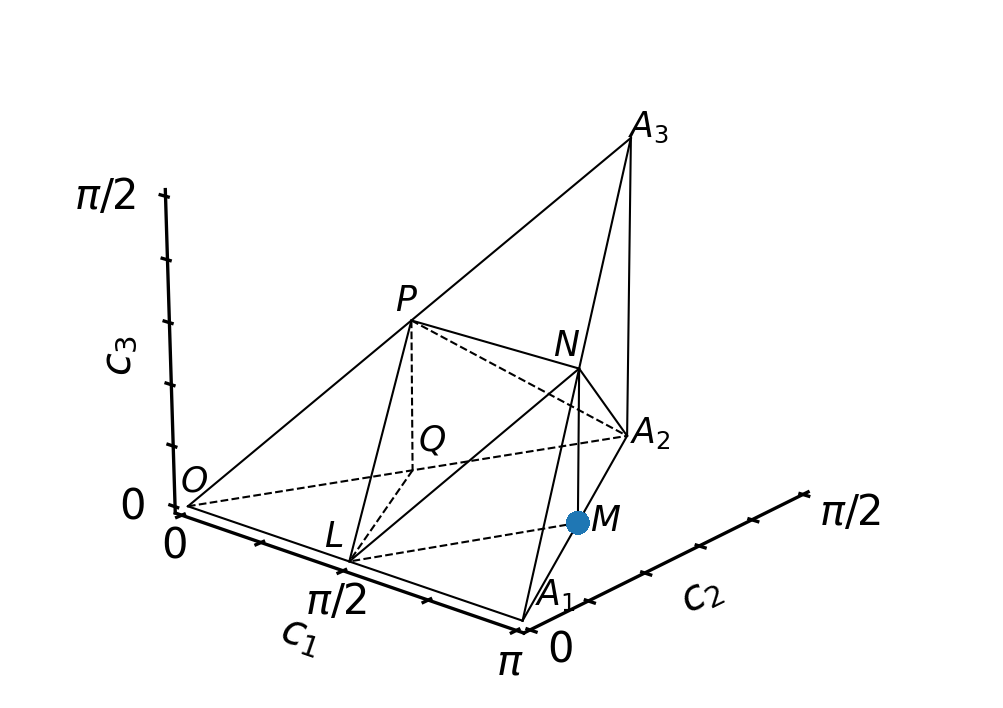

In [21]:
def sample(param_list, N=1000):
    # want to characterize the vectors from 2,2, template
    qc = template_circuit(param_list[:1])
    temp_qc = qc.assign_parameters(
        {parameter: np.random.random() * 2 * np.pi for parameter in qc.parameters}
    )
    global_phase, (a, b, c), K1l, K1r, K2l, K2r = KAKDecomp(Operator(temp_qc).data)
    starting_coordinates = (a, b, c)

    list_coordinates = []

    for _ in range(N):
        qc = template_circuit(param_list)
        parameters = qc.parameters
        temp_qc = qc.assign_parameters(
            {parameter: np.random.random() * 2 * np.pi for parameter in parameters}
        )
        global_phase, (a, b, c), K1l, K1r, K2l, K2r = KAKDecomp(Operator(temp_qc).data)
        temp_coordinates = (a, b, c)
        list_coordinates.append(temp_coordinates)
        c1, c2, c3 = weylchamber.c1c2c3(gate)
        w.add_point(c1, c2, c3)
        temp_vector = np.array(temp_coordinates) - np.array(starting_coordinates)
        # print(temp_vector)

    return list_coordinates


w = WeylChamber()
list_coordinates = sample(param_list=[3, 2])
w.plot()
# print(list_coordinates)

import scipy.spatial as ss
import numpy as np

hull = ss.ConvexHull(list_coordinates)
print("volume inside points is: ", hull.volume)

In [6]:
import numpy as np
import qutip
import matplotlib
import matplotlib.pylab as plt
import weylchamber
from weylchamber.visualize import WeylChamber

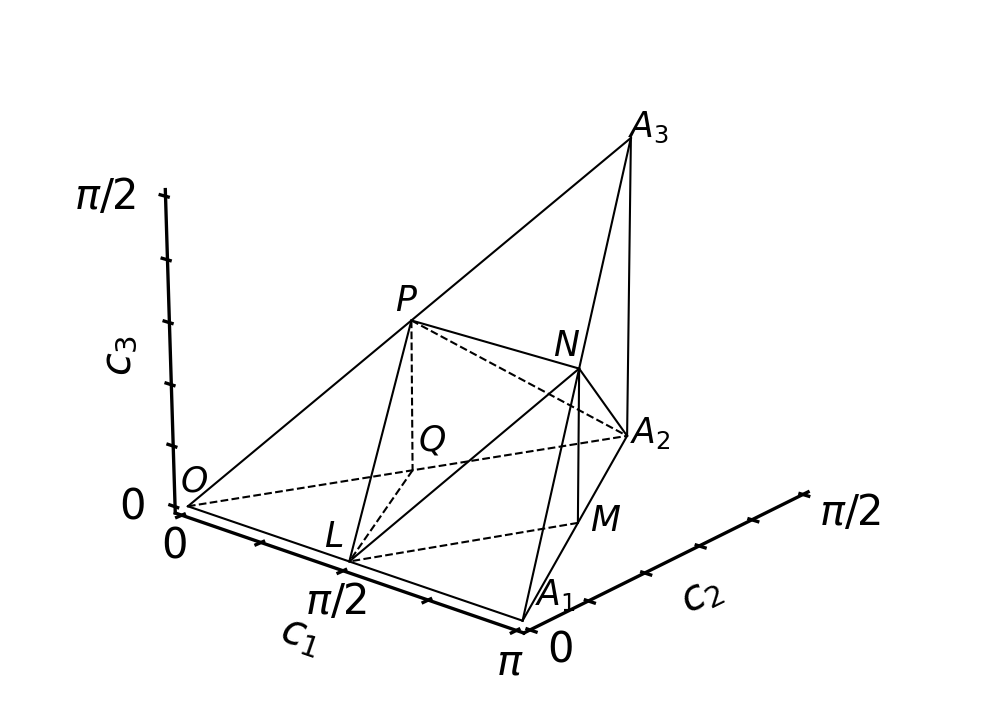

In [7]:
WeylChamber().plot()

In [9]:
IDENTITY = qutip.identity([2, 2])
CNOT = qutip.qip.operations.cnot()
CPHASE = qutip.qip.operations.cphase(np.pi)
BGATE = qutip.qip.operations.berkeley()
iSWAP = qutip.qip.operations.iswap()
sqrtISWAP = qutip.qip.operations.sqrtiswap()
sqrtSWAP = qutip.qip.operations.sqrtswap()
MGATE = weylchamber.canonical_gate(3 / 4, 1 / 4, 0)

Weyl Chamber Coordinates
----------------------------------
  Identity: 	0.00π 0.00π 0.00π
      CNOT: 	0.50π 0.00π 0.00π
    CPHASE: 	0.50π 0.00π 0.00π
     BGATE: 	0.50π 0.25π 0.00π
     iSWAP: 	0.50π 0.50π 0.00π
 sqrtISWAP: 	0.25π 0.25π 0.00π
  sqrtSWAP: 	0.75π 0.25π 0.25π
     MGATE: 	0.75π 0.25π 0.00π


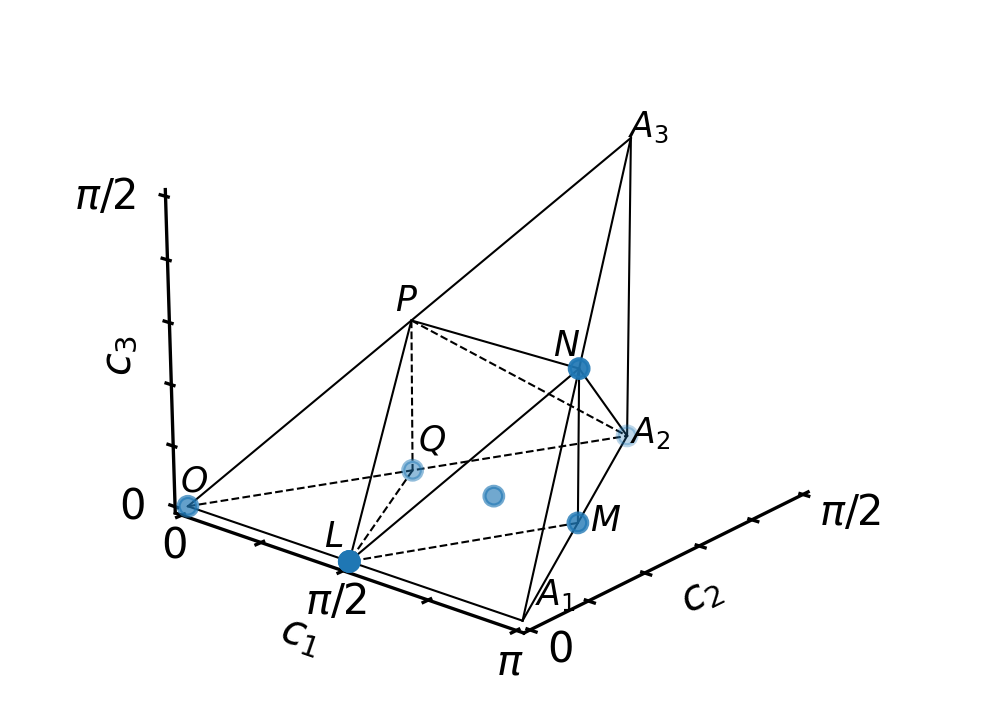

In [10]:
w = WeylChamber()
list_of_gates = [
    ("Identity", IDENTITY),
    ("CNOT", CNOT),
    ("CPHASE", CPHASE),
    ("BGATE", BGATE),
    ("iSWAP", iSWAP),
    ("sqrtISWAP", sqrtISWAP),
    ("sqrtSWAP", sqrtSWAP),
    ("MGATE", MGATE),
]
print("Weyl Chamber Coordinates")
print("----------------------------------")
for name, gate in list_of_gates:
    c1, c2, c3 = weylchamber.c1c2c3(gate)
    print("%10s: \t%.2fπ %.2fπ %.2fπ" % (name, c1, c2, c3))
    w.add_point(c1, c2, c3)
w.plot()

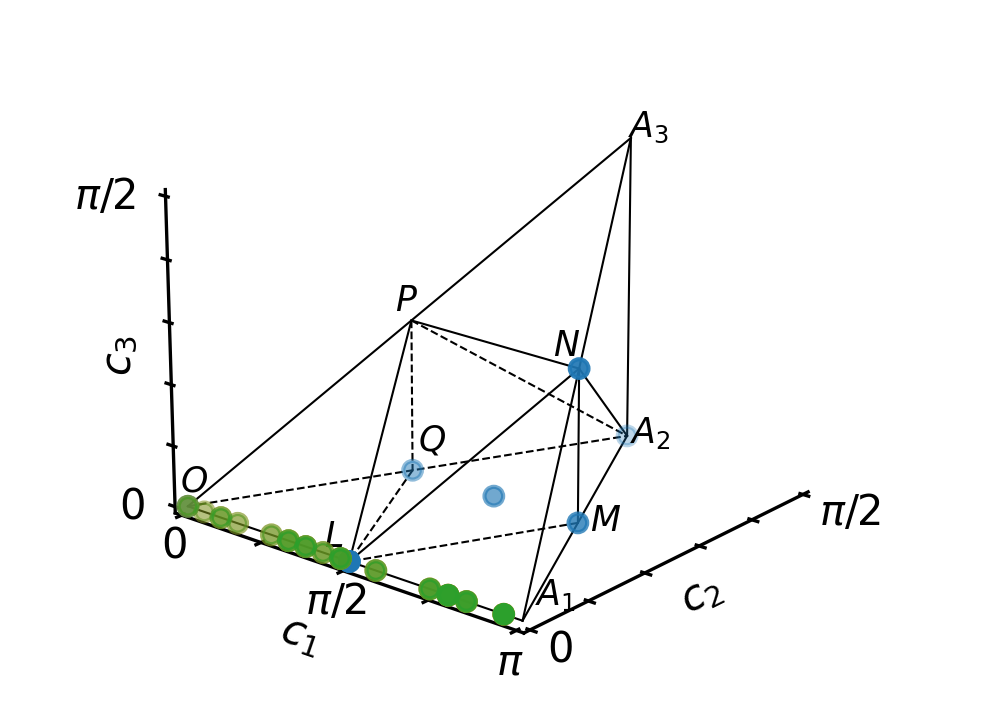

In [12]:
w.scatter(
    *zip(
        *[
            weylchamber.c1c2c3(qutip.qip.operations.cphase(phase))
            for phase in np.linspace(0, 2 * np.pi, 20)
        ]
    )
)
w.plot()

In [13]:
print("Local Invariants")
print("----------------------------------")
for name, gate in list_of_gates:
    g1, g2, g3 = weylchamber.g1g2g3(gate)
    print("%10s: \t%5.2f %5.2f %5.2f" % (name, g1, g2, g3))

Local Invariants
----------------------------------
  Identity: 	 1.00  0.00  3.00
      CNOT: 	 0.00  0.00  1.00
    CPHASE: 	 0.00  0.00  1.00
     BGATE: 	 0.00 -0.00  0.00
     iSWAP: 	 0.00  0.00 -1.00
 sqrtISWAP: 	 0.25  0.00  1.00
  sqrtSWAP: 	 0.00 -0.25  0.00
     MGATE: 	 0.25  0.00  1.00
